Preprocessing images into PATCH_SIZE patches with OVERLAP.
Saving into npz file containing train,val, test images.

Last updated: 07.06

Change: patch size 256, only taking first 11 depths to standardize input.




In [ ]:
# !pip install tifffile
# !pip install sklearn
# !pip install scikit-image

In [ ]:
# Constant values
IMG_SIZE = 512
OVERLAP = 0
PATCH_SIZE = 512
TRAIN_SIZE = 0.75
VAL_SIZE = 0.15
TEST_SIZE = 1-TRAIN_SIZE-VAL_SIZE
NUM_OF_DEPTHS = 11 # number of depths to use among all stacks
PATCH_PER_IMG = 0
TYPES = ['NADH'] # up to 3 types: NADH, FAD, SDG
MAIN_PATH = r"/objective_transfer"
# NPZ_VER = "3D" # version of data split
NPZ_VER = "_clean_b20t5_norm" # version of data split

In [ ]:
# importing dependencies
import IPython.display as ipd
import numpy as np
import sklearn
import sklearn.model_selection
import skimage
import math
import numpy as np
from sklearn import preprocessing
import psutil
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import time

In [ ]:
# Open drive dynamically; prefer drives that have 'drive' in their name.
MAIN_DIR= r"/objective_transfer/deep_learning"
from google.colab import drive
drive.mount('/content/drive')
os.chdir(MAIN_DIR+'/CAREstd/')

# FUNCTIONS

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def create_patches(img, patch_shape, slide):
  # returns stack of patches and number of patches
  patch_img = skimage.util.view_as_windows(img, (patch_shape,patch_shape), step=patch_shape-slide)
  # # stacking patches
  # patch = np.zeros((patch_img.shape[0]*patch_img.shape[1],patch_shape,patch_shape))
  # # creating 3D array by stacking patches by rows
  # for row in range(patch_img.shape[0]):
  #     start = row*patch_img.shape[1]
  #     end = row*patch_img.shape[1]+patch_img.shape[1]
  #     patch[row*patch_img.shape[1]:row*patch_img.shape[1]+patch_img.shape[1],:,:] = patch_img[row, :, :,:]
  patch = patch_img.reshape(patch_img.shape[0]*patch_img.shape[1],patch_shape,patch_shape) # more time efficient
  return patch

def merge_patches(img, patch_shape, slide):
  #  merging patches
  row_len = int(math.sqrt(img.shape[0]))
  patches = np.zeros((row_len,row_len,patch_shape,patch_shape))
  print(patches.shape)
  for r in range(row_len):
      patches[r,:,:,:] = img[r*row_len:r*row_len+row_len,:,:]
  plt.figure(5)
  plt.imshow(patches[1,1,:,:])
  return revert_img(patches,patch_shape, slide)

def revert_img(img, patch_shape, slide):
  # reverts original image and removes overlaps by splitting overlap over 2 images
  step = int(patch_shape-slide)
  reconstructed_arr = np.zeros((1024,1024))
  for x in range(img.shape[0]):
    for y in range(img.shape[1]):
      start_x = int(slide/2)
      start_y = int(slide/2)
      end_x = 0
      end_y = 0
      if x == 0:
        start_x = 0
        end_x = int(slide/2)
      if y == 0:
        start_y = 0
        end_y = int(slide/2)
      if x == img.shape[0]-1: end_x = int(slide/2)
      if y == img.shape[1]-1: end_y = int(slide/2)
      x_pos, y_pos = x * step + start_x, y * step + start_y
      print(x, y, )
      reconstructed_arr[x_pos : x_pos + step + end_x, y_pos : y_pos + step + end_y] = img[x, y, start_x:start_x+step+end_x, start_y:start_y+step+end_y]
  return reconstructed_arr

def normalize(img):
  # Normalizing images between 0 and 1
  # img = img - img.min()
  # img = np.divide(img, img.max())
  # Normalizing images between 0 and 1 and preserving distribution
  img_norm = (img - np.amin(img))/( np.amax(img)- np.amin(img))
  return img_norm

def normalize_percentile(img, pmin=0.1, pmax=99.9, clip = False):
  eps=1e-20 # avoid zero division
  mi = np.percentile(img,pmin,axis=None,keepdims=True)
  ma = np.percentile(img,pmax,axis=None,keepdims=True)
  if clip == True: return np.clip((img - mi) / ( ma - mi + eps ), 0, 1)
  return (img - mi) / ( ma - mi + eps )

def concatenate(A,B):
  return np.concatenate((A,B)) if len(A)>0 else B

In [ ]:
# PREPROCESSING
# normalizing, NOT splitting into patches, and then returning data, label arrays
def preprocess_data(ddict, key, types='NADH', process="up"):
  shape = np.shape(ddict['25X'][types][key])
  data = np.empty((shape[2],shape[0],shape[1]))
  labels = np.empty((shape[2],shape[0],shape[1]))
  num_depths = shape[2] # number of depths
  # for every 2D image/every depth
  for i in range(num_depths):
      # print("i: ",i)
      # Generating image patches with overlaps with chosen patch sizes and normalize
      # if not patchifying, img size == patch size; data_dict['40X']['NADH'][roi_name]
      A = ddict['25X'][types][key][:, :, i];
      B = ddict['40X'][types][key][:, :, i];
      # A = ddict['25X'][types][key][:, :, i],pmin=20, pmax=95,clip = True)
      # B = ddict['40X'][types][key][:, :, i],pmin=20, pmax=95,clip = True)
      # appending, depending whether we are upscaling or downscaling
      if process=="down":
        C = A
        A = B
        B = C
      data[i,:,:] = A[:,:]
      labels[i,:,:] = B[:,:]
  return [data, labels]

In [ ]:
def plotTwo(allThree, title, hist=False, save=False, savePath = None):
  # # plot and saving merged images
  # fig, ax = plt.subplots(2, 2, figsize=(20,20)) # change later
  # print(np.shape(ax))
  # fig.suptitle(title, fontsize=16)
  # if hist:
  #   if np.shape(allThree[0])[0] > 1:
  #     raw = allThree[0].flatten()
  #     pred = allThree[1].flatten()
  #   else:
  #     raw = allThree[0]
  #     pred = allThree[1]
  #   ax[1,0].set_ylim([0, 16000])
  #   ax[1,0].hist(raw, bins=100)
  #   ax[1,1].set_ylim([0, 16000])
  #   ax[1,1].hist(pred, bins=100)
  #   ax[0,0].imshow(allThree[0], cmap='gray')
  #   ax[0,1].imshow(allThree[1], cmap='gray')

  # ax[0,0].set_title("Input image")
  # ax[0,1].set_title("GT image")
  # # ax[0].axis("off")
  # # ax[1].axis("off")
  # # ax[2].axis("off")
  # # plt.show()
  # if save:
  #   fig.savefig(MAIN_DIR+"/data/"+title)
    # plot and saving merged images
  fig, ax = plt.subplots(1, 2, figsize=(20,10)) # change later
  print(np.shape(ax))
  fig.suptitle(title, fontsize=16)
  if hist:
    if np.shape(allThree[0])[0] > 1:
      raw = allThree[0].flatten()
      pred = allThree[1].flatten()
    else:
      raw = allThree[0]
      pred = allThree[1]
    ax[0].set_ylim([0, 30000])
    ax[0].hist(raw, bins=100)
    ax[1].set_ylim([0, 30000])
    ax[1].hist(pred, bins=100)
  else:
    ax[0].imshow(allThree[0], cmap='gray')
    ax[1].imshow(allThree[1], cmap='gray')

  ax[0].set_title("Input image")
  ax[1].set_title("GT image")
  plt.show()


# EXECUTION BELOW

In [ ]:
main_path = MAIN_PATH
os.chdir(main_path+'/shifted_files')
data_dict = {'40X':{'NADH':{}, 'FAD':{}, 'SHG':{}}, '25X':{'NADH':{}, 'FAD':{}, 'SHG':{}}}
files = os.listdir()
results_folders = []
key_names = [] # to contain file names (ROIs) without '.mat'

# Populating dictionary
NADH = 0 # counting number of images
FAD = 0
# for result_folder in results_folders:
roi_mats = [] # to contain full file names
# os.chdir(result_folder)
experiment_files = os.listdir()
print(experiment_files)
# appending .mat files with w40XShift to roi_mats
for experiment_file in experiment_files:
    if experiment_file.endswith('.mat') and '512_shifted' in experiment_file:
        roi_mats.append(experiment_file)

mean40x = []
mean25x = []


for roi in roi_mats:
    roi_name = roi[0:-4]
    print(roi_name)
    key_names.append(roi_name)
    mat_data = sio.loadmat(roi)
    # print(np.shape(mat_data['u']['nadh_512_shifted'][0][0]))
    # data_dict['40X']['NADH'][roi_name] = mat_data['nadh_512_shifted'][:, :, 3:-3, 1]
    # data_dict['25X']['NADH'][roi_name] = mat_data['nadh_512_shifted'][:, :, 3:-3, 0]
    data_dict['40X']['NADH'][roi_name] = mat_data['u'][:, :, :, 1] # Artem messed up saving Mat files
    data_dict['25X']['NADH'][roi_name] = mat_data['u'][:, :, :, 0]
    print("")
    print("==================================================")
    print("NOW PRINTING: ", roi_name)
    print("")
del mat_data


print(NADH)
print(FAD)

In [ ]:
# we are splitting train test val based on stacks, we have a total of 15 stacks
# we are generating 3D patches with each patch is 3D over set of depths of interest
training_indices = [0, 2, 4, 5,6, 8, 9,10,11,12,7]
training_keys = [key_names[i] for i in training_indices]
val_indices = [1, 3]
val_keys = [key_names[i] for i in val_indices]
# test_indices = [12, 13]
# test_keys = [key_names[i] for i in test_indices]

training_data = []
training_data_labels = []
# test_data = []
# test_data_labels = []
val_data = []
val_data_labels =[]
# max_depth = 10 # only taking total of 11 depths for consistency

for key in key_names:
    [data, label] = preprocess_data(data_dict, key, types='NADH', process="up")
    print(np.shape(data))
    # for i in range(0,len(data)):
    #     plotTwo([data[i],label[i]], 'data, label'+str(i)+" "+str(key), hist=True, save=True)
    if key in training_keys:
        training_data = concatenate(training_data,data)
        training_data_labels = concatenate(training_data_labels,label)
    elif key in val_keys:
        # print("validation")
        val_data = concatenate(val_data,data)
        val_data_labels = concatenate(val_data_labels,label)
    # elif key in test_keys:
    #     test_data = concatenate(test_data,data)
    #     test_data_labels = concatenate(test_data_labels,label)

(20, 512, 512)
(18, 512, 512)
(26, 512, 512)
(19, 512, 512)
(13, 512, 512)
(17, 512, 512)
(14, 512, 512)
(8, 512, 512)
(7, 512, 512)
(31, 512, 512)
(30, 512, 512)
(23, 512, 512)
(3, 512, 512)


KeyError: ignored

In [ ]:
print(np.shape(training_data)+np.shape(val_data))

(192, 512, 512, 37, 512, 512)


(2,)


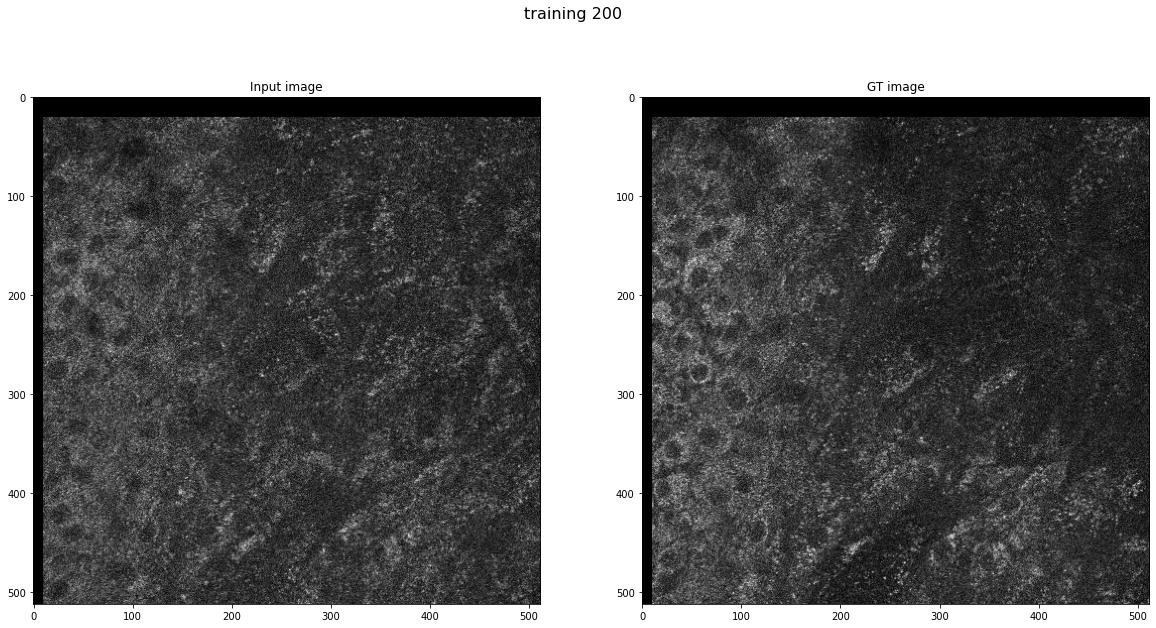

In [ ]:
# plotTwo([training_data[30],training_data_labels[30]],'training 200',)
plotTwo([training_data[20],training_data_labels[20]],'training 200',)

# plotTwo([val_data[25],val_data_labels[25]],'training 200')
# plotTwo([val_data[20],val_data_labels[20]],'val 20',hist=True)
# plotTwo([val_data[20],val_data_labels[20]],'val 20')

# ***FFT***
Localized normalization by applying fourier transform on blurred image to segment regions with varying intensities and normalize them independently

In [ ]:
def normalizeTail(img, bottom=0, tail=100):
  return normalize_percentile(img, pmin=bottom, pmax=tail, clip = True)

In [ ]:
import cv2

In [ ]:
fil = 10

# background illumination correction using low pass filter on time domain through Fourier transform. Subtraction in spatial domain
def correct_illumination_spatial(img, filter_radius=fil):
  img_fft = np.fft.fftshift(np.fft.fft2(img))
  f_shape = np.shape(img_fft)
  filter = np.zeros(f_shape,dtype=np.float64)
  center = np.array(f_shape)/2.0

  for iy in range(f_shape[0]):
    for ix in range(f_shape[1]):
        filter[iy,ix] = (iy- center[0])**2 + (ix - center[1])**2 < filter_radius **2

  f_filtered = filter * img_fft
  f_filtered_shifted = np.fft.fftshift(f_filtered)

  inv_img = np.fft.ifft2(f_filtered_shifted) # inverse F.T.
  inv_img = inv_img.astype(np.float64)
  filtered_img = cv2.blur(src=inv_img, ksize=(30,30)) # 20 looked okay
  plotTwo([inv_img,filtered_img],"fssada")
  # not normalizing filtered image as distribution has not changed
  result = normalizeTail(img-filtered_img,bottom=0.1, tail=99.9)
  return result

  # background illumination correction using low pass filter on time domain through Fourier transform. Subtraction in frequency domain
def correct_illumination_freq(img, filter_radius=fil):
  img_fft = np.fft.fftshift(np.fft.fft2(img))
  f_shape = np.shape(img_fft)
  filter = np.zeros(f_shape,dtype=np.float64)
  center = np.array(f_shape)/2.0

  for iy in range(f_shape[0]):
    for ix in range(f_shape[1]):
        filter[iy,ix] = (iy- center[0])**2 + (ix - center[1])**2 < filter_radius **2

  f_filtered = filter * img_fft
  f_filtered_shifted = np.fft.fftshift(img_fft) - np.fft.fftshift(f_filtered)
  inv_img = np.fft.ifft2(f_filtered_shifted) # inverse F.T.
  filtered_img = inv_img
  filtered_img = filtered_img.astype(np.float64)
  # not normalizing filtered image as distribution has not changed
  result = normalizeTail(filtered_img,bottom=0.1, tail=99.9)
  return result

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


(2,)


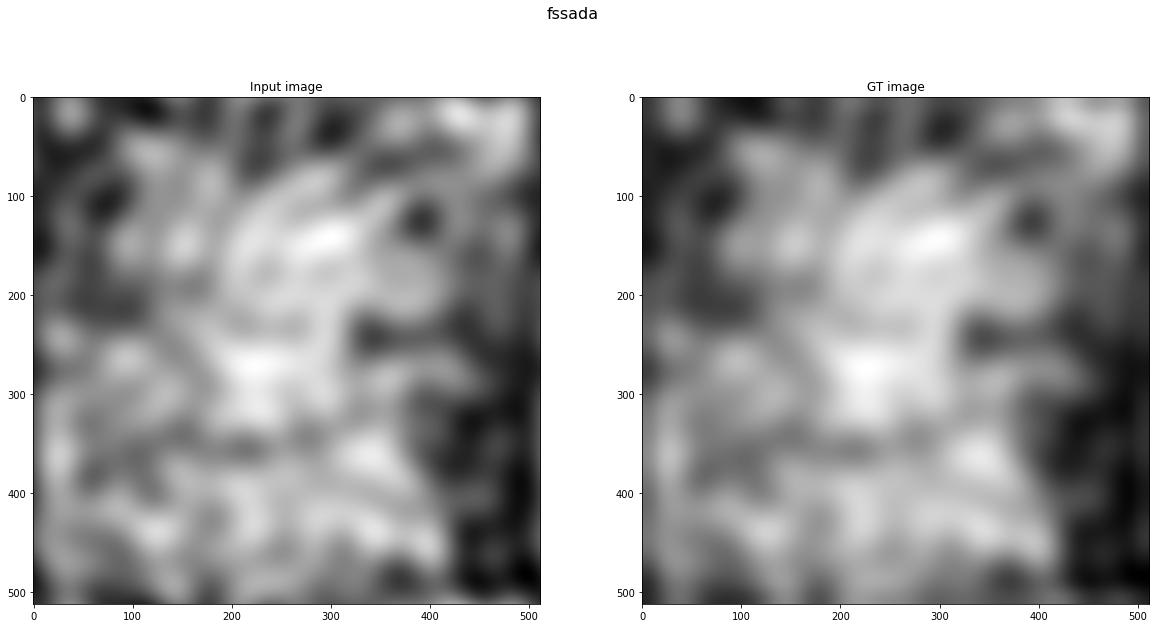

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: ComplexWarning: Casting complex values to real discards the imaginary part


In [ ]:
img = normalizeTail(training_data_labels[180],bottom=0, tail=99.5)
spatial = normalizeTail(correct_illumination_spatial(img),bottom=0, tail=100)
freq = normalizeTail(correct_illumination_freq(img),bottom=0, tail=100)

(2,)


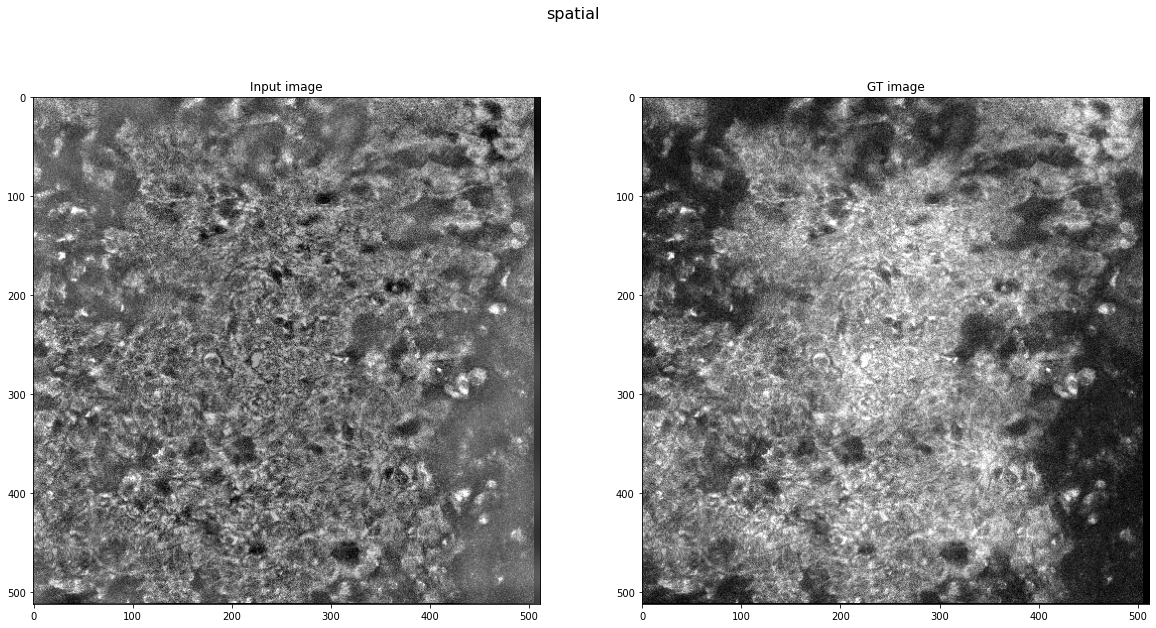

(2,)


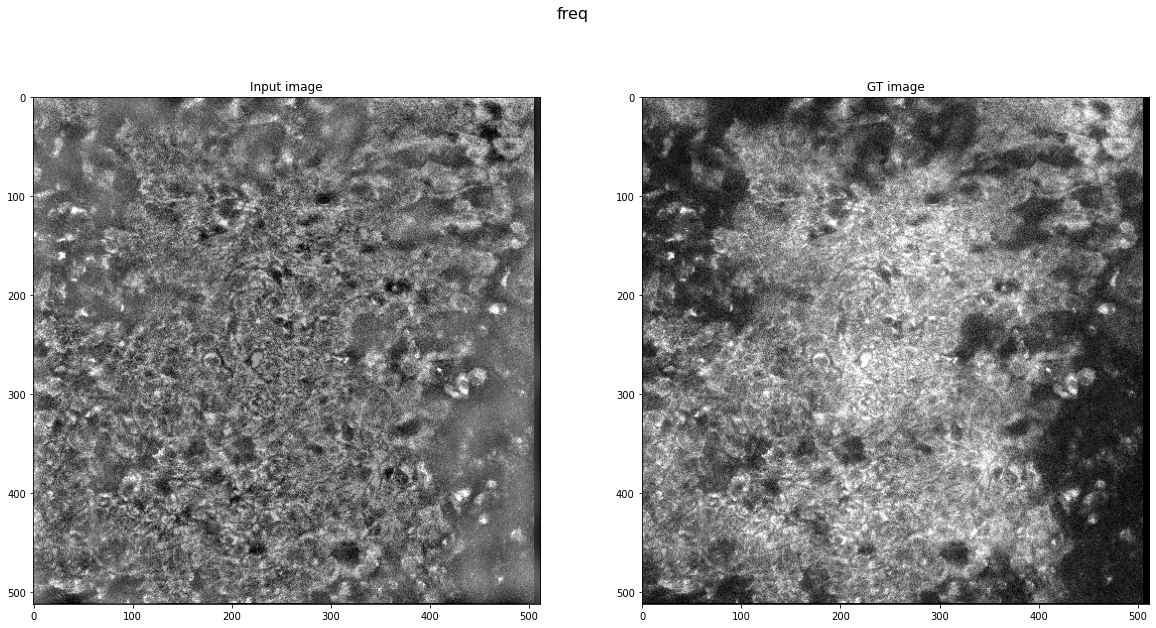

(2,)


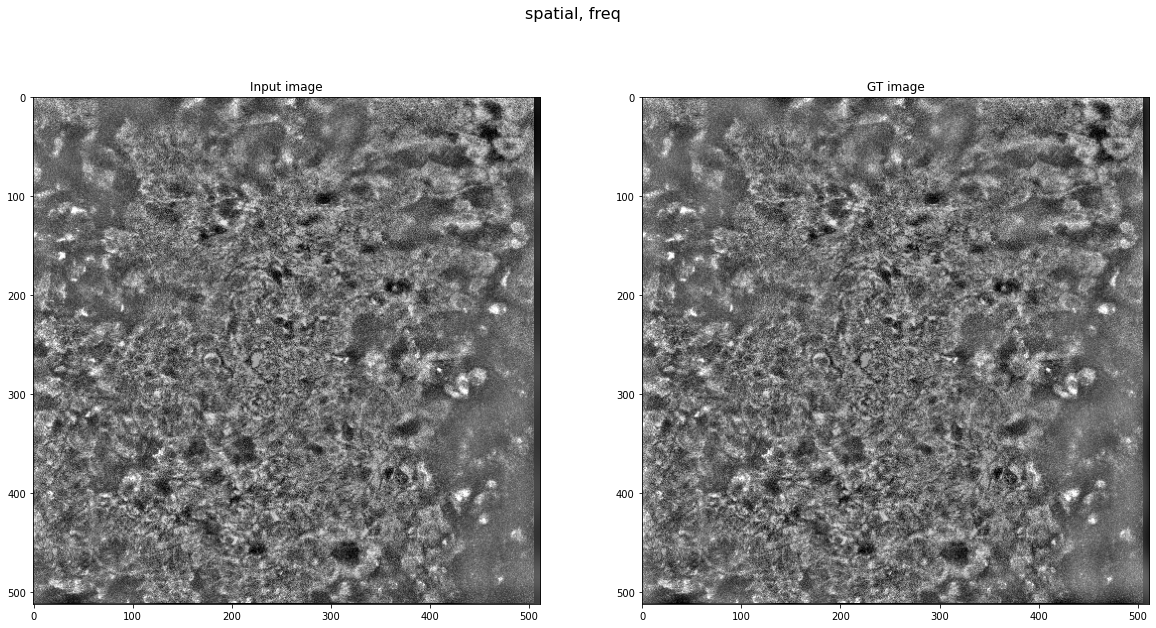

(2,)


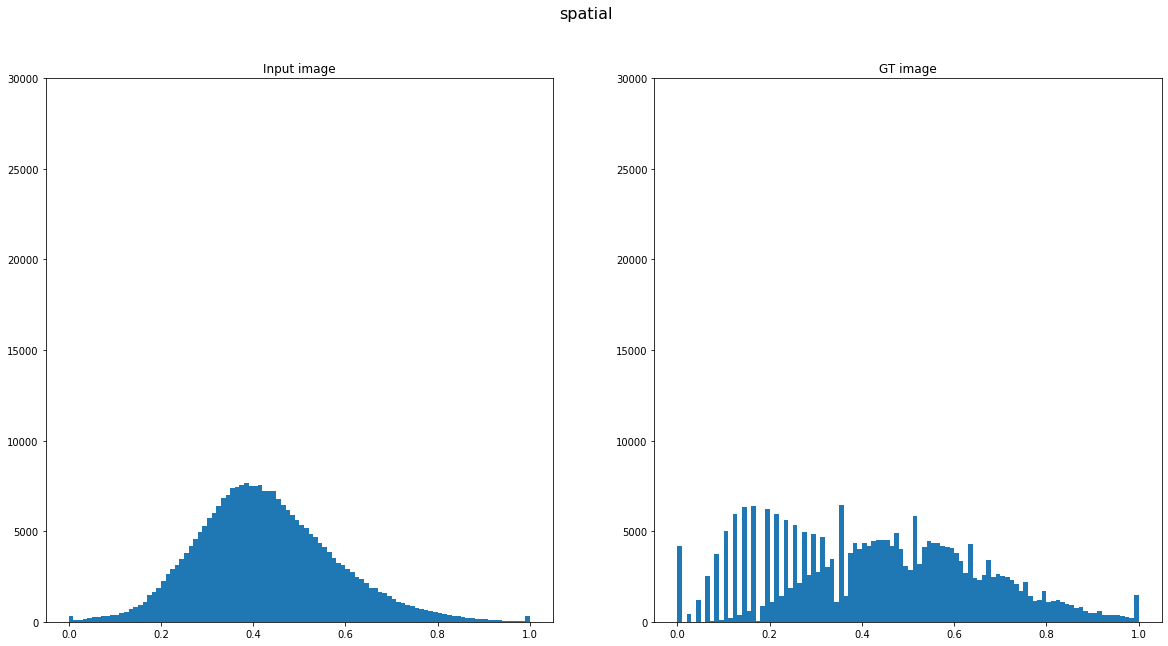

(2,)


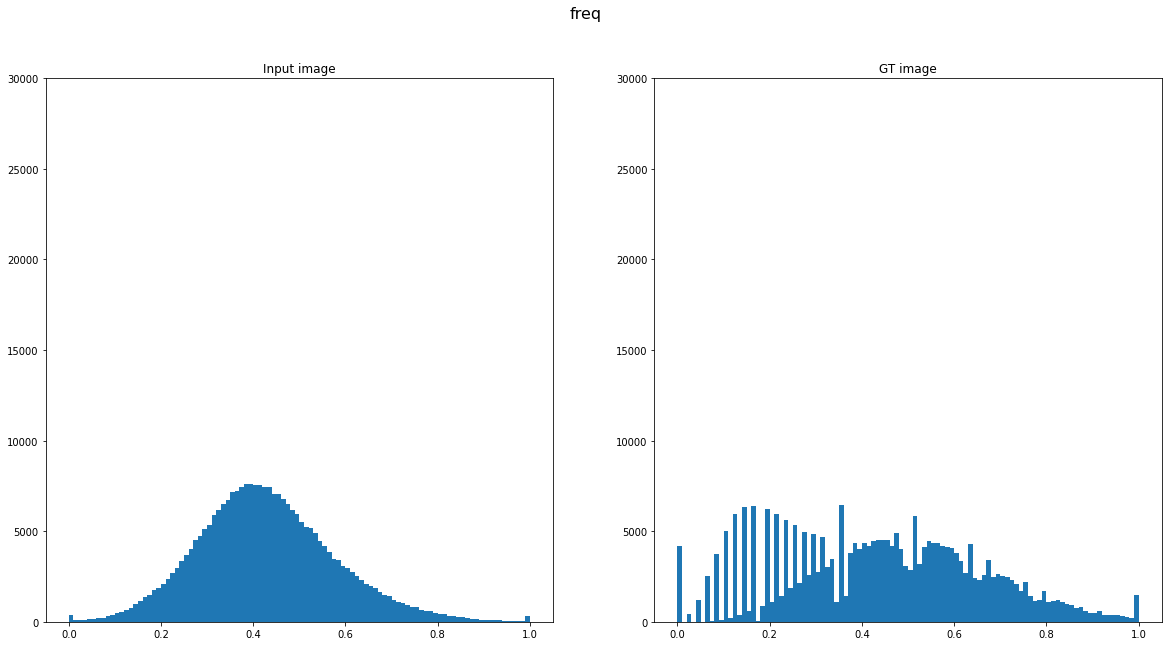

(2,)


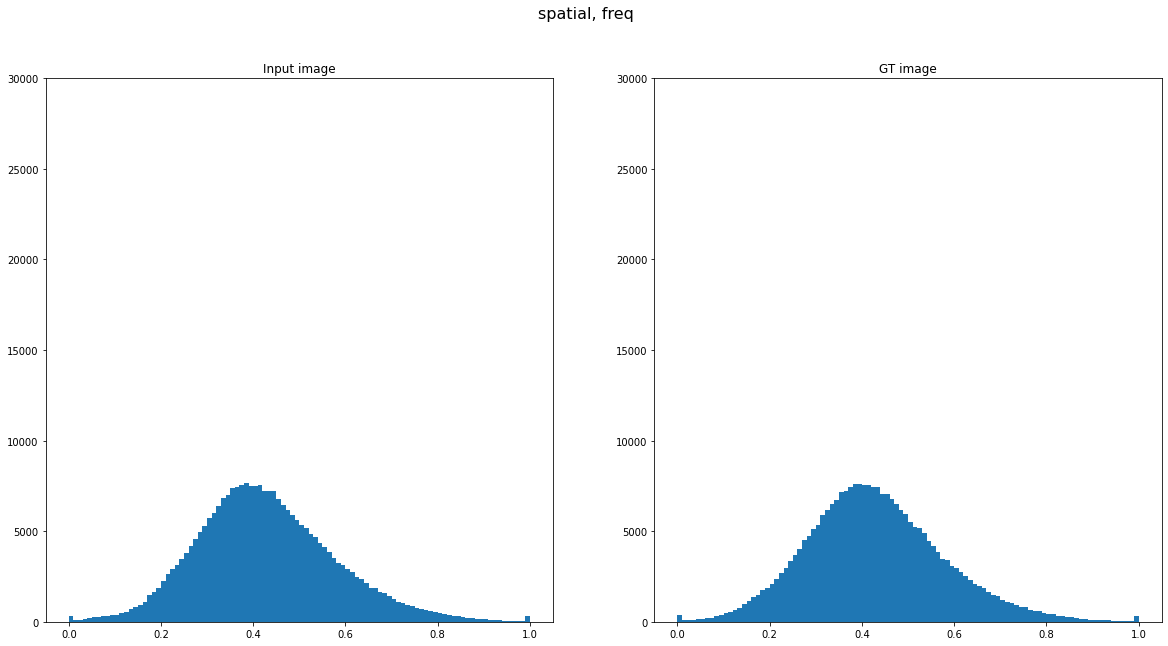

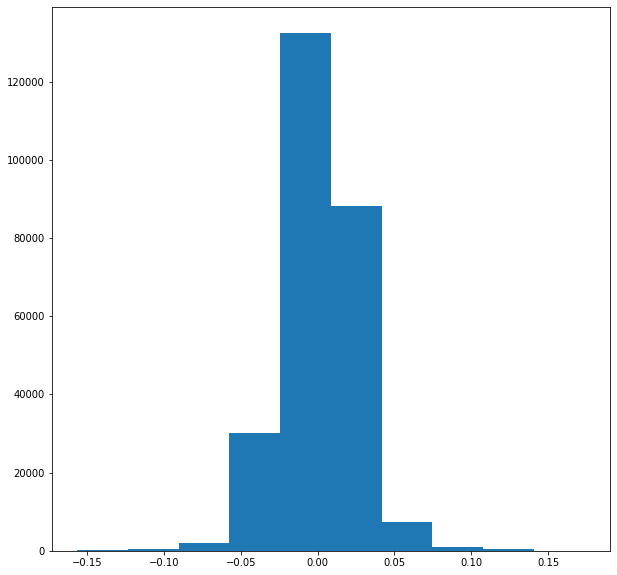

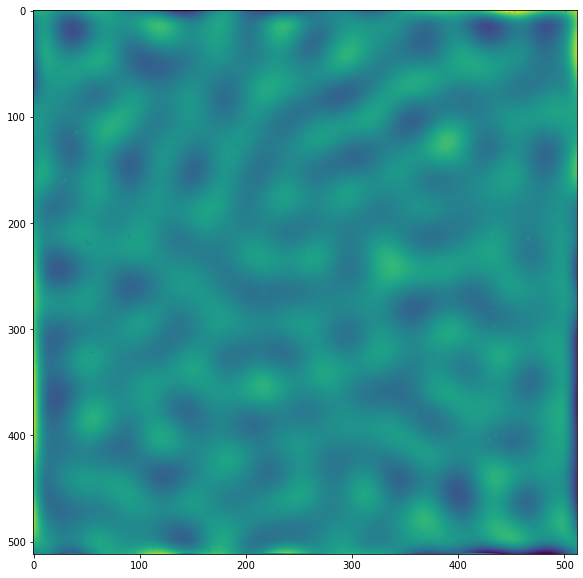

In [ ]:
plotTwo([spatial, img],'spatial',hist=False)
plotTwo([freq, img],'freq',hist=False)
plotTwo([spatial, freq],'spatial, freq',hist=False)
plotTwo([spatial, img],'spatial',hist=True)
plotTwo([freq, img],'freq',hist=True)
plotTwo([spatial, freq],'spatial, freq',hist=True)
plt.figure(1, figsize=[10,10])
diff = freq-spatial
plt.hist(diff.flatten())
plt.figure(2, figsize=[10,10])
plt.imshow(diff)

(2,)


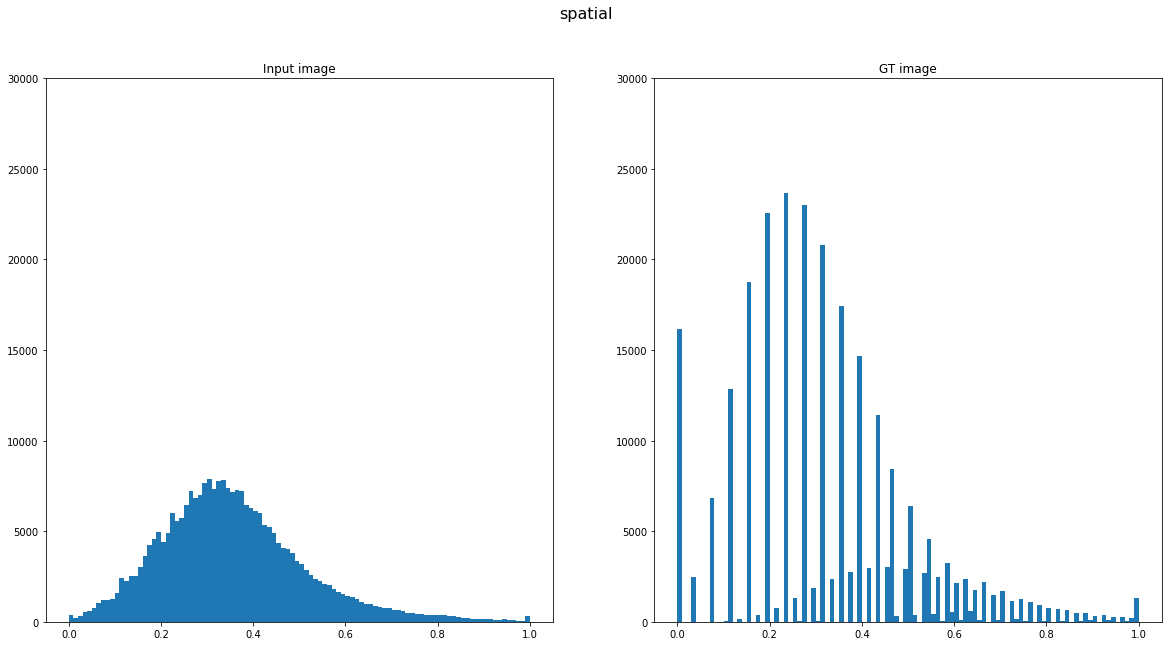

(2,)


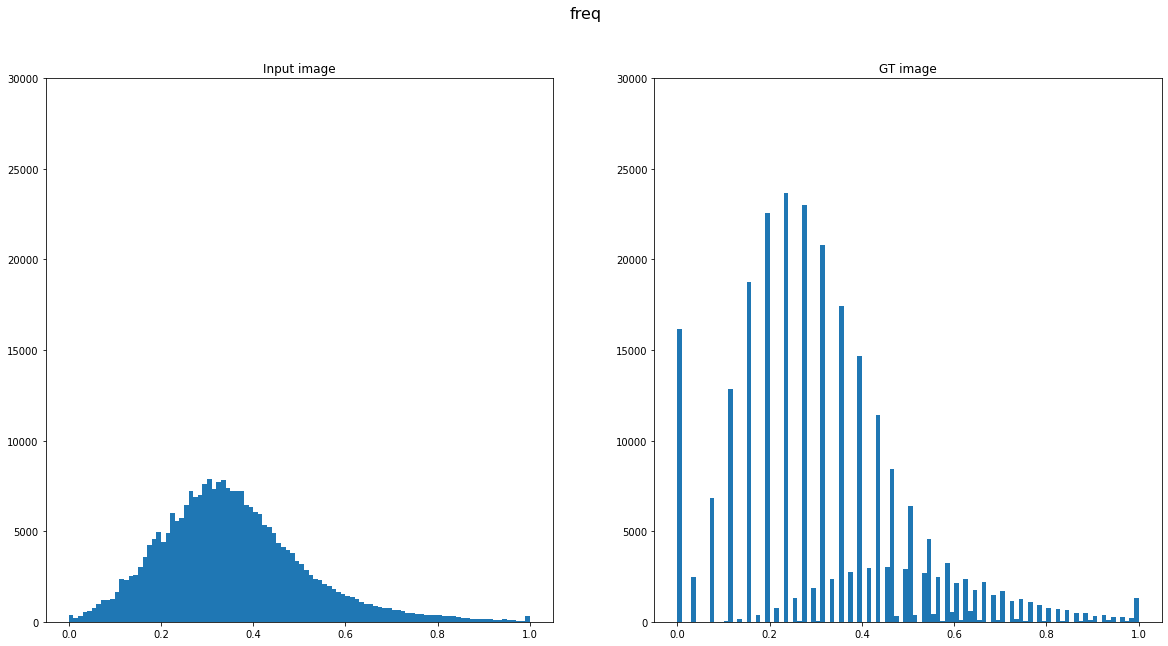

In [ ]:
plotTwo([spatial, img],'spatial',hist=True)
plotTwo([freq, img],'freq',hist=True)

In [ ]:
# img = normalize(training_data_labels[30])
img = normalizeTail(training_data_labels[2],100)
img_fft = np.fft.fftshift(np.fft.fft2(img))
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(np.log(abs(img_fft)), cmap='gray');

In [ ]:
# filter design: a circular low pass filter
pass_radius = 15 # 5 worked okay
f_shape = np.shape(img_fft)
filter = np.zeros(f_shape,dtype=np.float64)
center = np.array(f_shape)/2.0

for iy in range(f_shape[0]):
    for ix in range(f_shape[1]):
        filter[iy,ix] = (iy- center[0])**2 + (ix - center[1])**2 < pass_radius **2
plotTwo([np.abs(np.fft.ifft2(np.fft.fftshift(filter * img_fft))), img],'test',hist=False)
plotTwo([np.abs(np.fft.ifft2(np.fft.fftshift(filter * img_fft))), img],'test',hist=True)

f_filtered = img_fft - filter * img_fft
plt.figure(0)
plt.imshow(filter,cmap='gray')
plt.figure(1)
plt.imshow(np.log(abs(f_filtered)), cmap='gray');


In [ ]:
# reversing
f_filtered_shifted = np.fft.fftshift(f_filtered)
inv_img = np.fft.ifft2(f_filtered_shifted) # inverse F.T.
filtered_img = np.abs(inv_img)
filtered_img = filtered_img.astype(np.float64)
filtered_img = normalizeTail(filtered_img,99.9) # normalizing with 5% top cap here